In [ ]:
import carla
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Connessione al simulatore CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(20.0)

# Ottenere il mondo
world = client.get_world()

# Creazione del veicolo
blueprint = world.get_blueprint_library().find('vehicle.tesla.model3')
spawn_point = world.get_map().get_spawn_points()[0]  # Posizione iniziale
vehicle = world.spawn_actor(blueprint, spawn_point)
vehicle.set_autopilot(True)
# Creare una telecamera di profondità (Depth Camera)
camera_blueprint = world.get_blueprint_library().find('sensor.camera.depth')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.5))  # Posizionare la telecamera sopra il veicolo
camera = world.spawn_actor(camera_blueprint, camera_transform, attach_to=vehicle)

# Funzione di callback per la telecamera
def process_depth_image(image):
    # Converti l'immagine in un formato utilizzabile (array NumPy)
    image_array = np.array(image.raw_data)
    image_array = image_array.reshape((image.height, image.width, 4))  # Riorganizza i dati in formato (H, W, 4)
    
    # L'array contiene i dati in formato BGRA (Blue, Green, Red, Alpha), estrai solo la componente R (profondità)
    depth_map = image_array[:, :, 2]  # La componente rossa contiene la profondità

    # Normalizza l'immagine per una visualizzazione migliore
    depth_map = np.array(depth_map, dtype=np.float32)
    depth_map = np.multiply(depth_map, 1.0 / 255.0)

    # Visualizza la mappa di profondità
    plt.imshow(depth_map, cmap='plasma')
    plt.colorbar()
    plt.show()

# Aggiungi la funzione di callback per ricevere i dati della telecamera
camera.listen(lambda image: process_depth_image(image))

# Fai partire il simulatore per un po' di tempo (ad esempio 10 secondi)
import time
time.sleep(10)

# Rimuovi gli attori quando hai finito
camera.destroy()
vehicle.destroy()


In [4]:
import carla
import numpy as np
import cv2
import matplotlib.pyplot as plt

class CarlaEnv:
    @staticmethod
    def collect_topdown_map(env, vehicle, camera, num_episodes=10, map_resolution=100, file_path="./topdown_map.png"):
        """
        Funzione per raccogliere i dati dalla telecamera di profondità e generare una mappa dall'alto
        :param env: ambiente CARLA
        :param vehicle: attore del veicolo
        :param camera: telecamera di profondità
        :param num_episodes: numero di episodi da raccogliere
        :param map_resolution: risoluzione della mappa (numero di celle per unità di distanza)
        :param file_path: percorso dove salvare la mappa
        """
        # Creazione di una mappa vuota
        map_size = (1000, 1000)  # Dimensione della mappa (in pixel)
        topdown_map = np.zeros(map_size, dtype=np.float32)

        print("start epoch")
        
        for i in range(num_episodes):
            print(f"start {i} epoch")
            obs = env.reset()
            done = False
            while not done:
                throttle, steer, brake = expert(obs)
                obs, _, done, _ = env.step(throttle, steer, brake)
                
                # Ottieni la profondità e la posizione del veicolo
                depth_image = camera.get_data()  # Acquisisci l'immagine di profondità
                vehicle_location = vehicle.get_location()  # Posizione del veicolo
                
                # Calcolare la posizione nella mappa 2D
                vehicle_x = int(vehicle_location.x * map_resolution)
                vehicle_y = int(vehicle_location.y * map_resolution)
                
                # Aggiungi la profondità alla mappa: proietta la profondità sui pixel della mappa
                depth_map = CarlaEnv.process_depth_image(depth_image)
                CarlaEnv.update_topdown_map(topdown_map, vehicle_x, vehicle_y, depth_map)

            print(f"end {i} epoch")

        # Salva la mappa
        cv2.imwrite(file_path, topdown_map * 255)  # Normalizza la mappa (per visualizzare bene)
        print(f"Top-down map saved to {file_path}")

    @staticmethod
    def process_depth_image(depth_image):
        """
        Elabora l'immagine di profondità e la restituisce come mappa 2D
        :param depth_image: immagine di profondità grezza
        :return: mappa 2D della profondità
        """
        # Converti l'immagine di profondità in un array NumPy (immagine BGRA)
        depth_array = np.array(depth_image.raw_data)
        depth_array = depth_array.reshape((depth_image.height, depth_image.width, 4))  # Riorganizza i dati in (H, W, 4)
        
        # Estrai la componente R (profondità) e normalizza
        depth_map = depth_array[:, :, 2]  # Componente rossa (profondità)
        depth_map = np.array(depth_map, dtype=np.float32)
        depth_map = np.multiply(depth_map, 1.0 / 255.0)  # Normalizza tra 0 e 1
        
        return depth_map

    @staticmethod
    def update_topdown_map(topdown_map, vehicle_x, vehicle_y, depth_map):
        """
        Aggiungi i dati di profondità alla mappa top-down 2D.
        :param topdown_map: mappa corrente
        :param vehicle_x: posizione X del veicolo sulla mappa
        :param vehicle_y: posizione Y del veicolo sulla mappa
        :param depth_map: mappa di profondità acquisita
        """
        # Usa la posizione del veicolo per determinare la porzione della mappa da aggiornare
        # (questo è solo un esempio, adatta alle tue esigenze)
        
        for dx in range(depth_map.shape[0]):  # Itera sulle righe della mappa di profondità
            for dy in range(depth_map.shape[1]):  # Itera sulle colonne della mappa di profondità
                distance = depth_map[dx, dy]  # Ottieni la profondità del pixel

                if distance > 0:  # Se c'è una distanza valida (non infinita)
                    # Aggiorna la mappa top-down (esempio: la profondità influisce sull'intensità del pixel)
                    x = vehicle_x + dx
                    y = vehicle_y + dy

                    if 0 <= x < topdown_map.shape[0] and 0 <= y < topdown_map.shape[1]:
                        topdown_map[x, y] = max(topdown_map[x, y], distance)  # Aggiungi la profondità, evita di sovrascrivere valori bassi



In [1]:
import carla

# Connessione a CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(20.0)
client.load_world('Town05')
world = client.get_world()

# Creazione del veicolo (opzionale, per avere un veicolo in movimento)
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.find('vehicle.tesla.model3')
spawn_point = carla.Transform(carla.Location(x=0, y=0, z=1), carla.Rotation(yaw=0))
vehicle = world.spawn_actor(vehicle_bp, spawn_point)

# Aggiunta della telecamera di profondità al veicolo
camera_bp = blueprint_library.find('sensor.camera.depth')
camera_transform = carla.Transform(carla.Location(x=2.5, y=0, z=1), carla.Rotation(pitch=-15))
depth_camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

# Funzione per ottenere i dati della telecamera
def process_image(image):
    depth_data = image.raw_data
    # Convertire i dati di profondità in una mappa o matrice 3D
    # (questo dipende dal formato della profondità)
    pass

# Impostazione della callback per processare l'immagine
depth_camera.listen(lambda image: process_image(image))


K matrix: [[400.   0. 400.]
 [  0. 400. 300.]
 [  0.   0.   1.]]
world frame: 47323
***************
local variable 'cur_frame' referenced before assignment
UnboundLocalError
157
***************
***************
Finally! Bye!
***************
actor "Actor(id=24, type=vehicle.tesla.model3)" was destroyed!
actor "Actor(id=25, type=sensor.camera.rgb)" was destroyed!
actor "Actor(id=26, type=sensor.camera.rgb)" was destroyed!


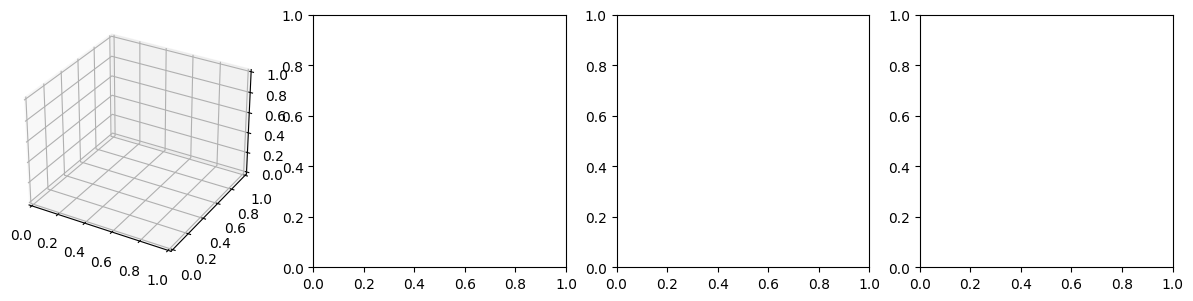

In [1]:
from stereo_visual_odometry import VehicleEnv

myEnv = VehicleEnv()
myEnv.visualize_trajectory()